In [2]:
! pip install numpy

In [3]:
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
! pip install tensorflow

In [5]:
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [6]:
data = open('x.txt', 'rb')
x = pickle.load(data)
data.close()

In [7]:
data = open('y.txt', 'rb')
y = pickle.load(data)
data.close()

In [11]:
#создание массива со значениями: отношение высоты и ширины, скорость пикселей в секунду

x_all = []
for video in x:
    x_prev = 0
    y_prev = 0
    x_video = []
    for frame in video:
        x_frame = [frame[1]/frame[2] if frame[1] and frame[2] and frame[1]/frame[2]<=12 else 0, 
                   (((frame[3]-x_prev)**2+(frame[4]-y_prev)**2)**0.5) if frame[3] and frame[4] and (((frame[3]-x_prev)**2+(frame[4]-y_prev)**2)**0.5)<=120 else 0]
        x_prev = frame[3]
        y_prev = frame[4]
        x_video.append(x_frame)
    x_all.append(x_video)
x_train = np.asarray(x_all)
x_train.shape

(87, 300, 2)

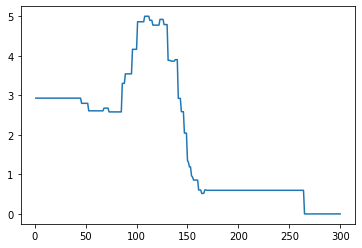

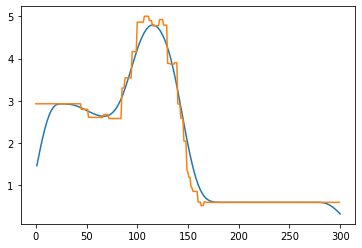

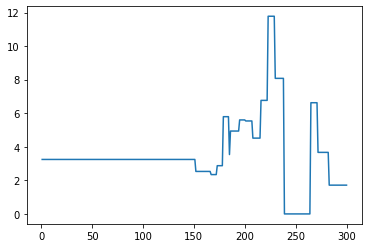

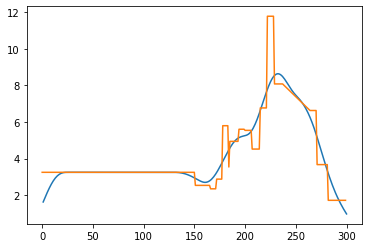

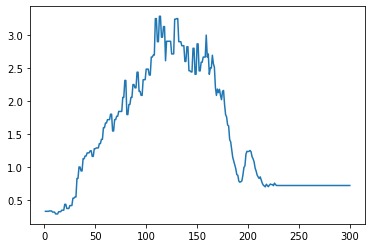

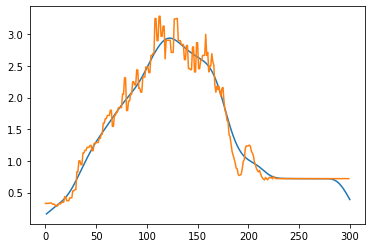

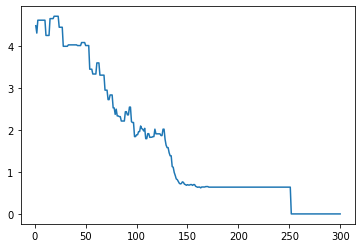

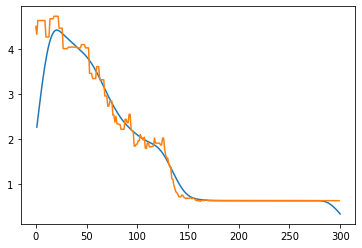

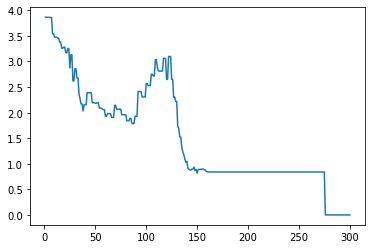

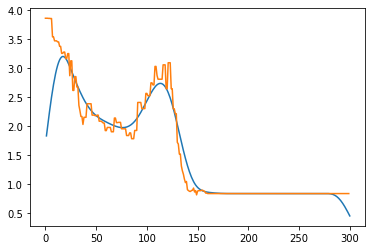

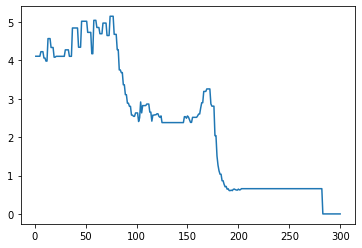

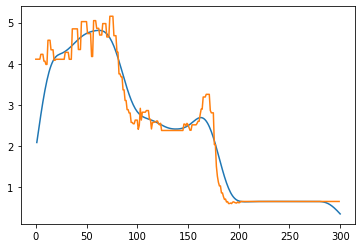

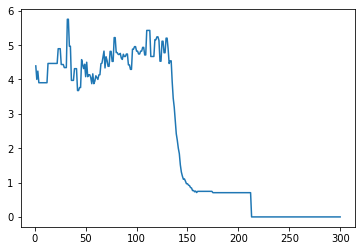

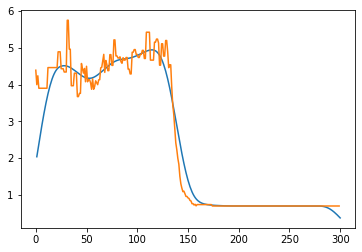

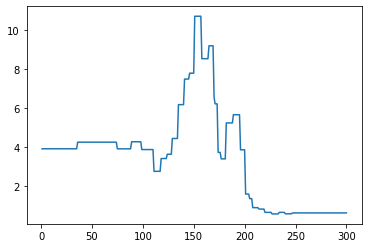

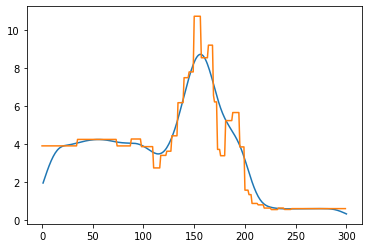

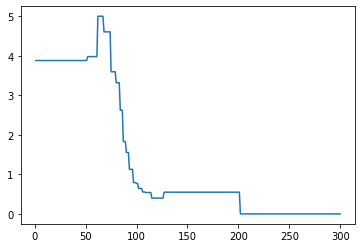

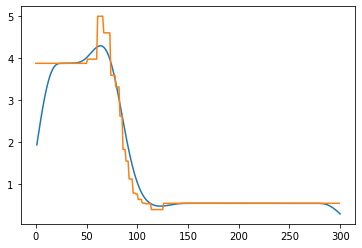

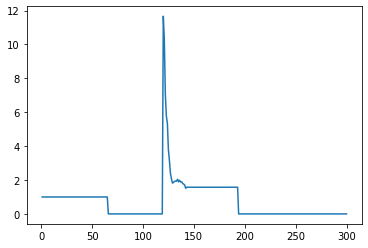

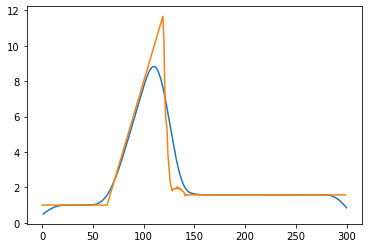

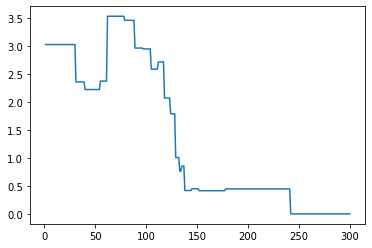

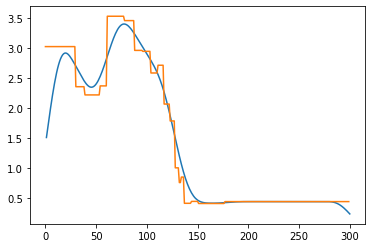

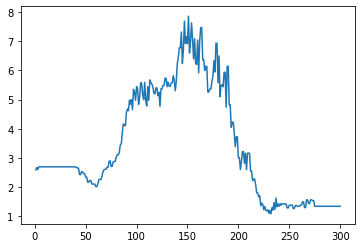

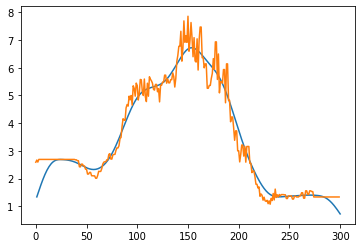

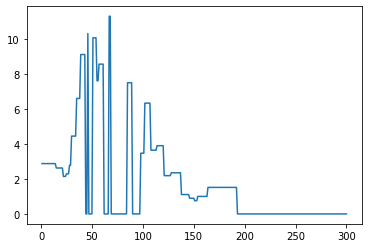

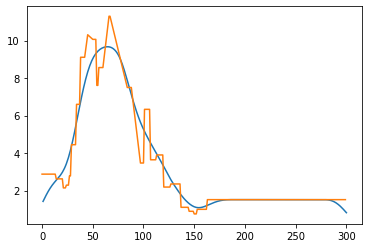

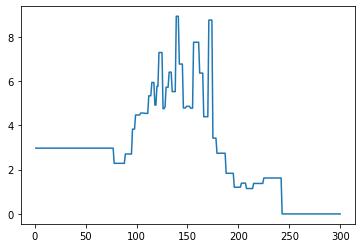

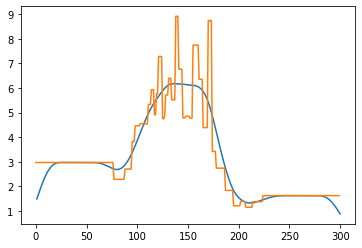

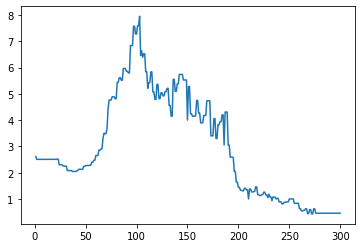

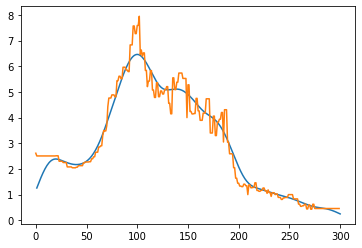

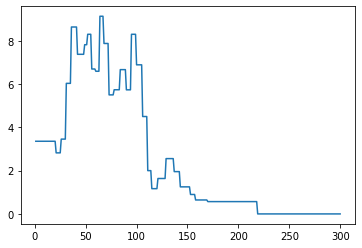

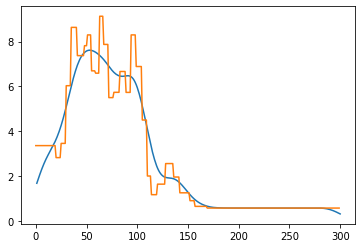

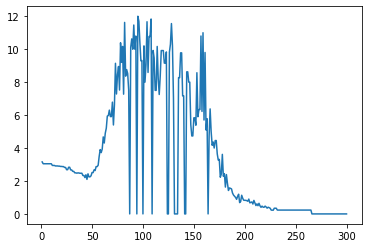

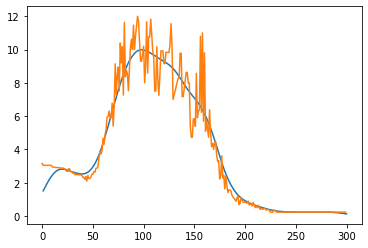

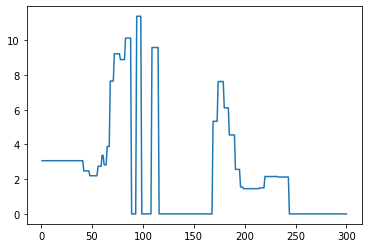

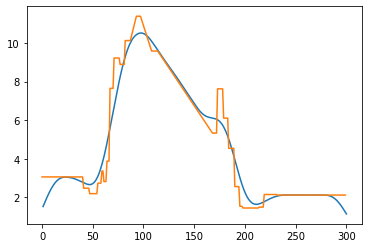

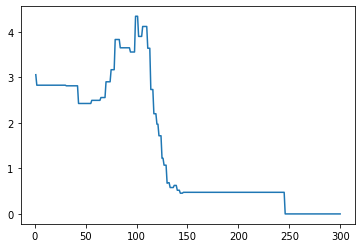

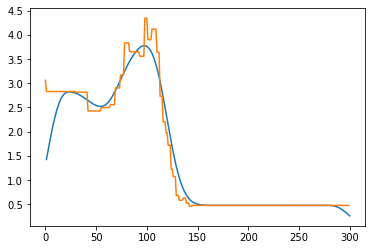

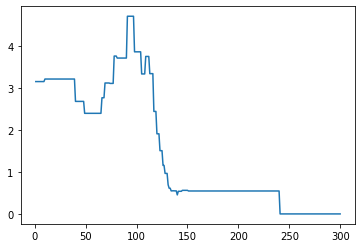

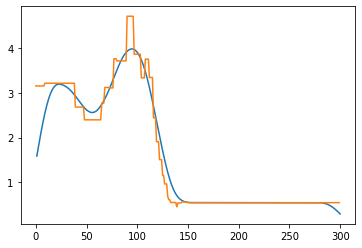

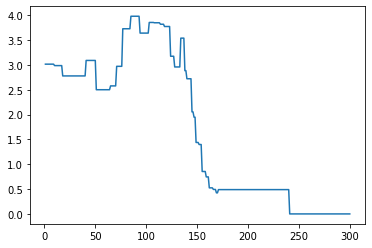

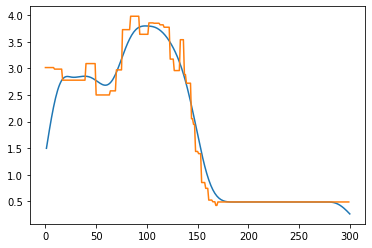

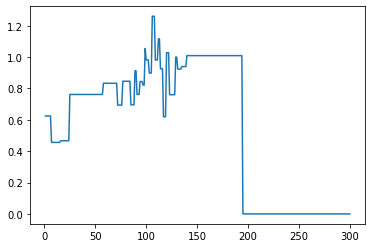

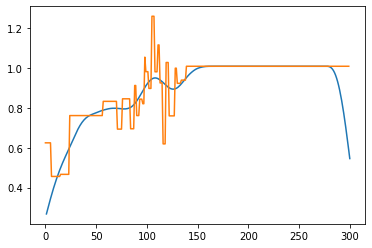

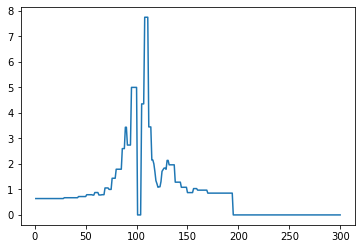

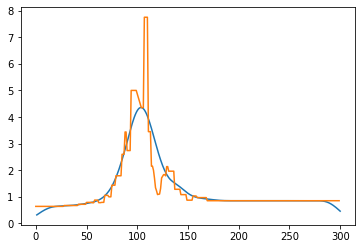

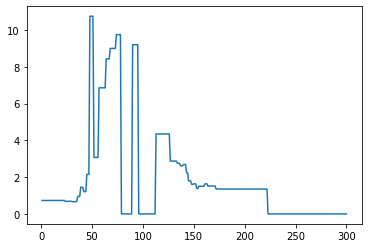

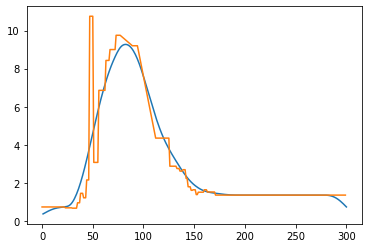

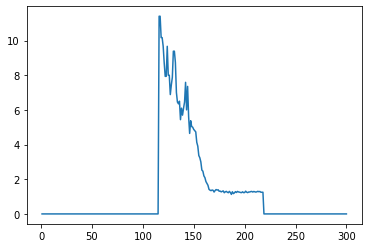

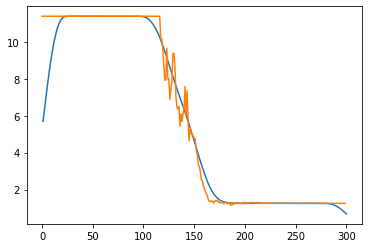

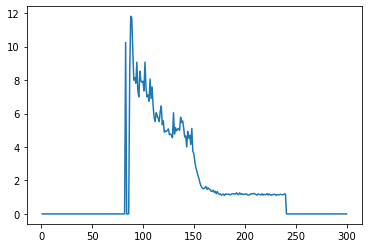

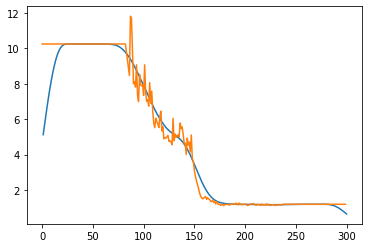

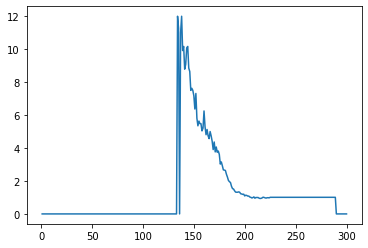

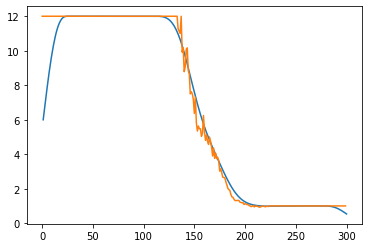

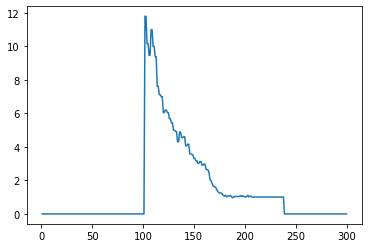

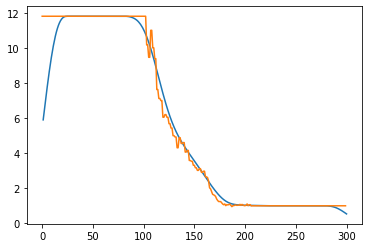

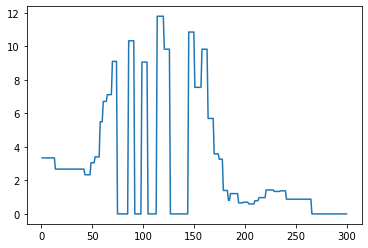

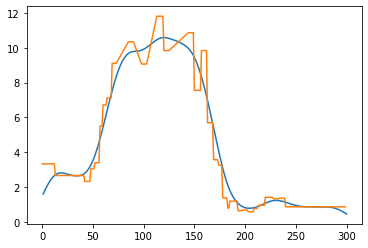

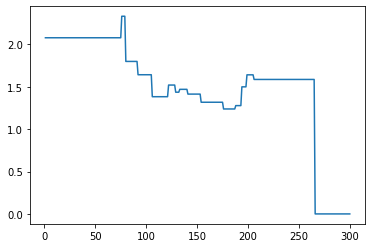

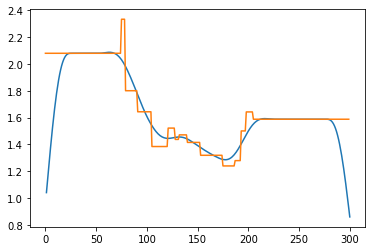

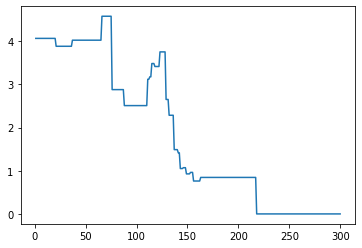

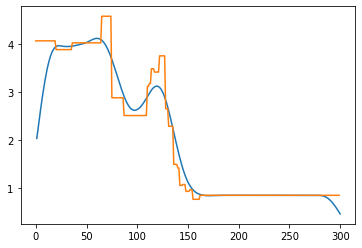

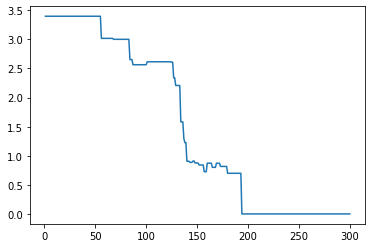

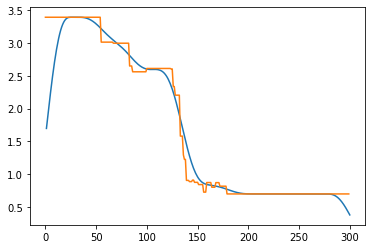

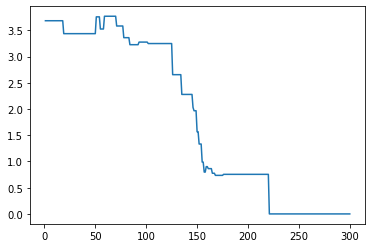

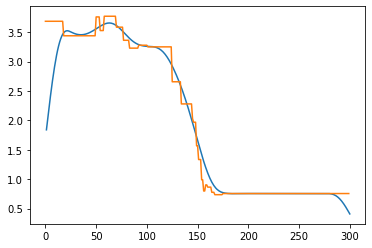

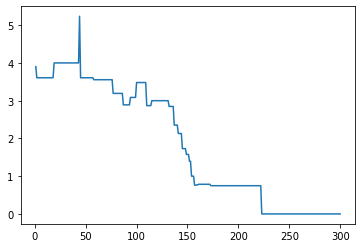

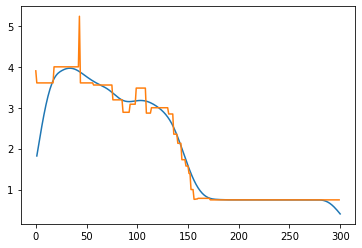

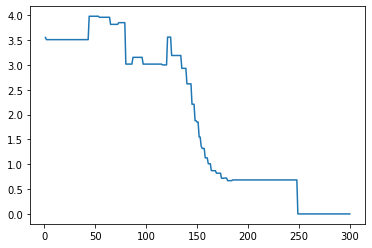

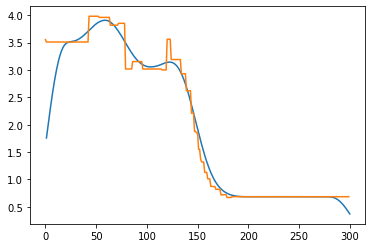

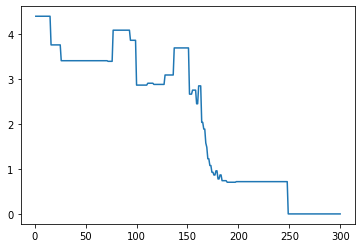

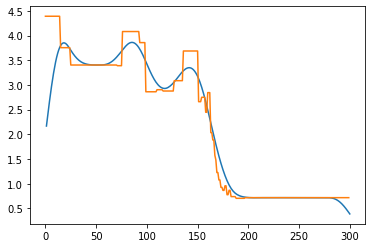

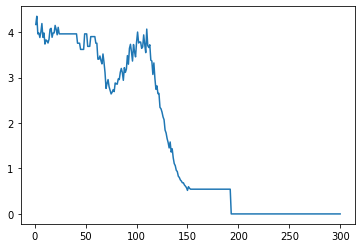

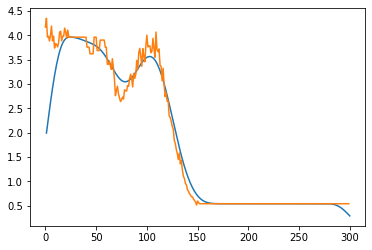

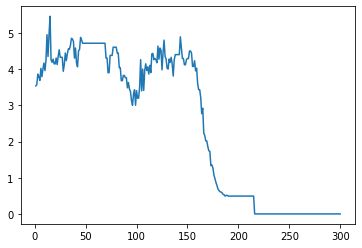

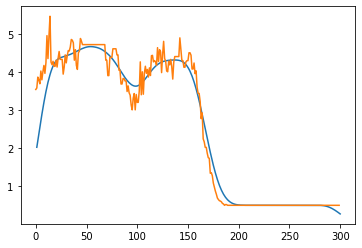

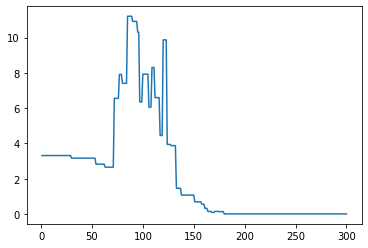

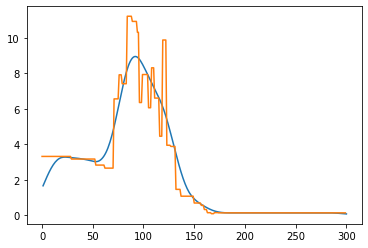

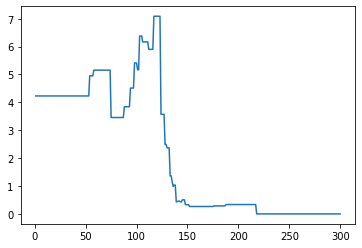

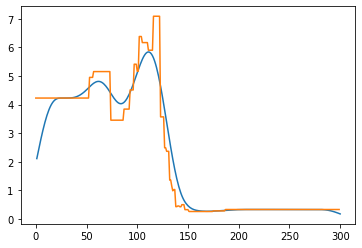

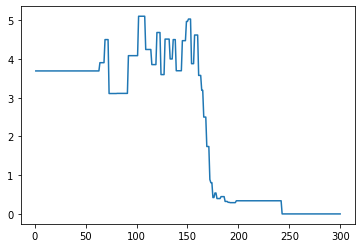

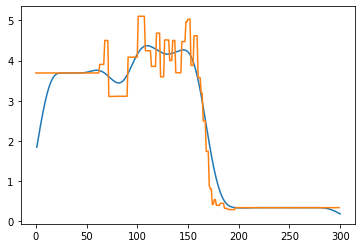

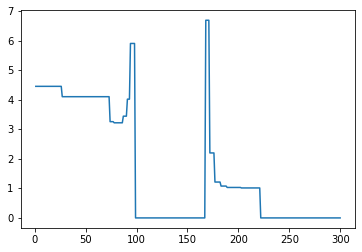

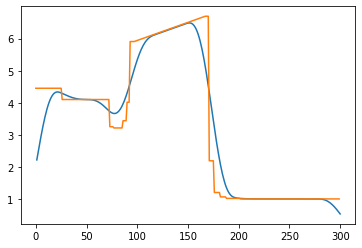

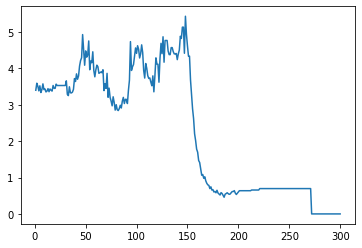

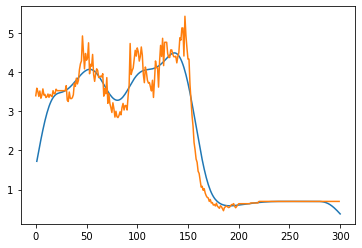

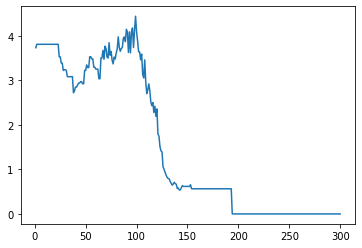

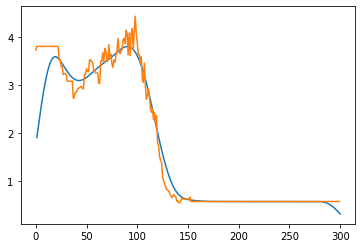

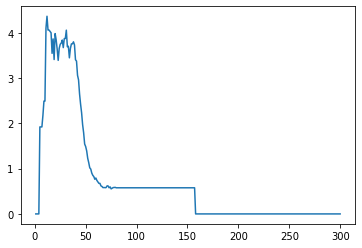

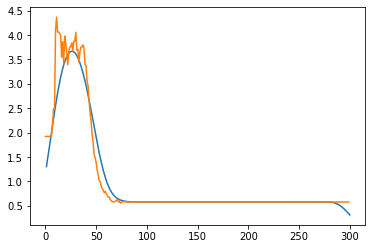

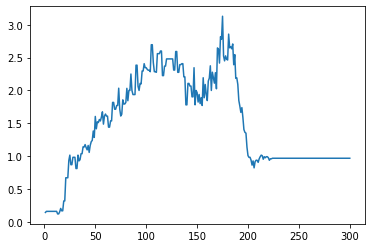

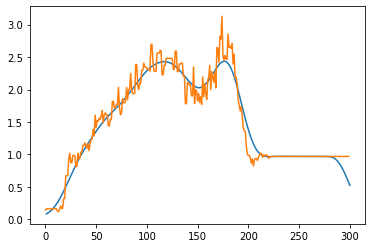

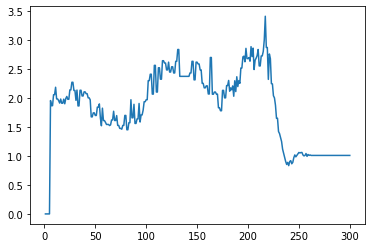

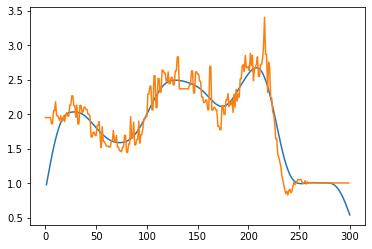

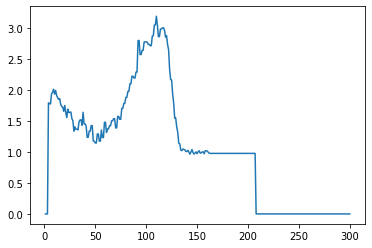

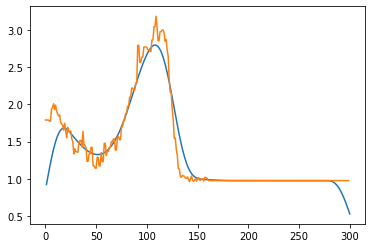

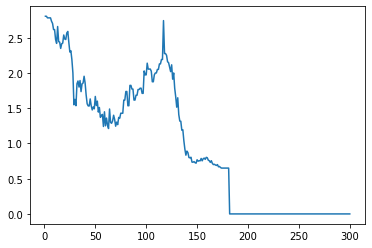

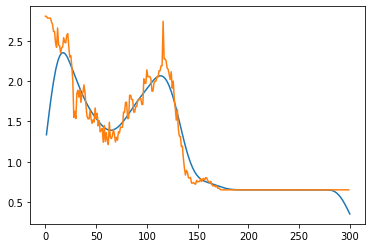

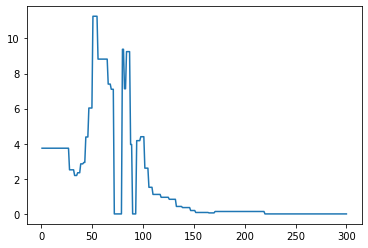

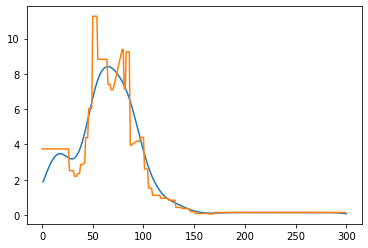

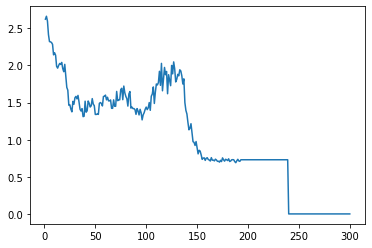

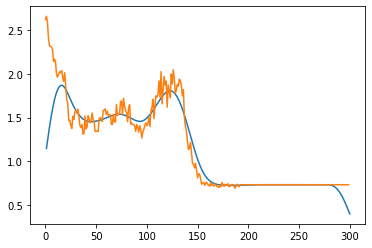

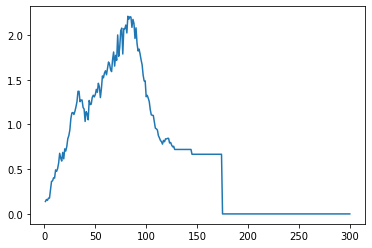

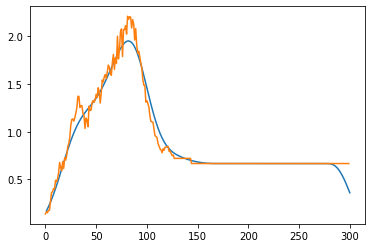

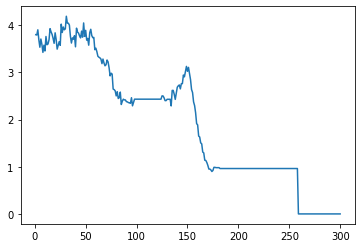

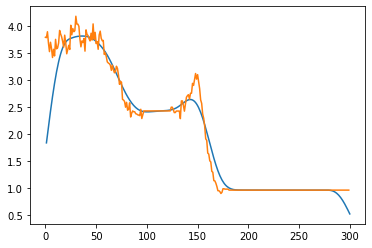

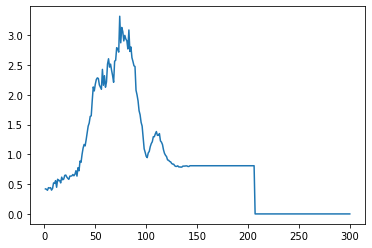

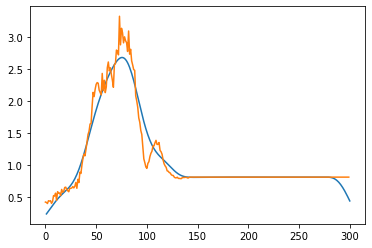

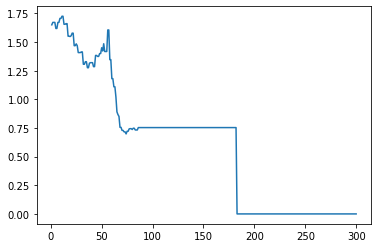

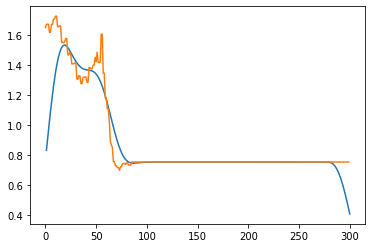

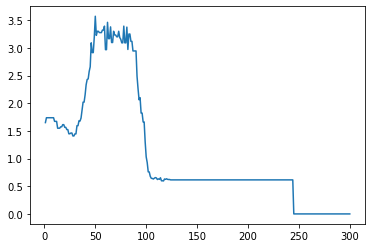

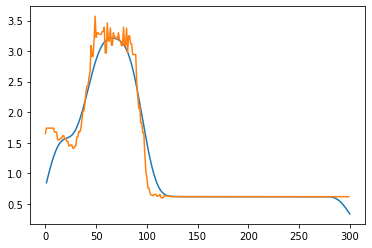

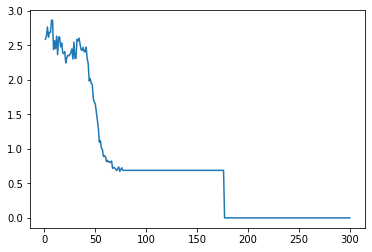

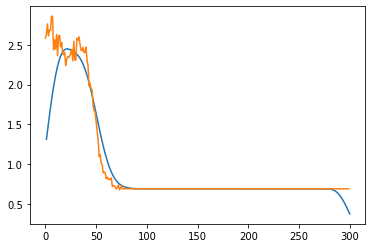

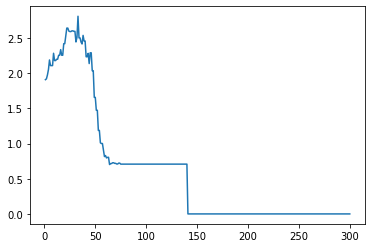

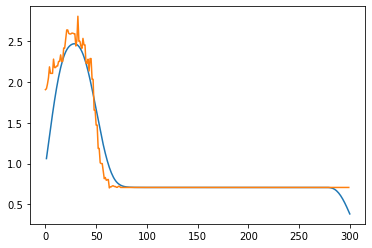

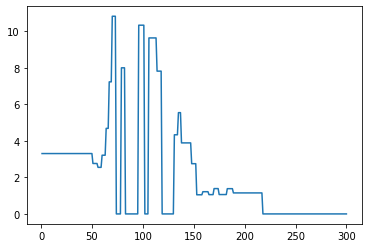

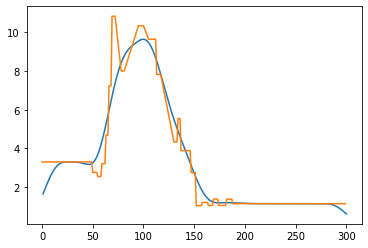

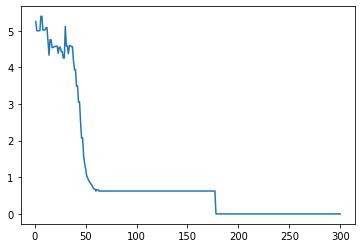

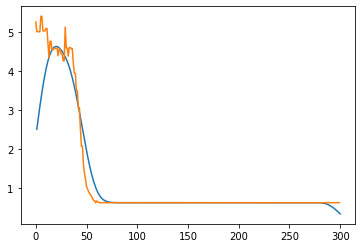

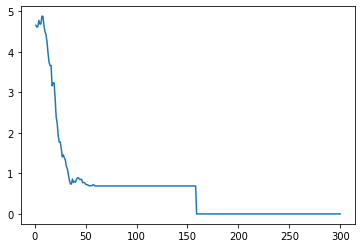

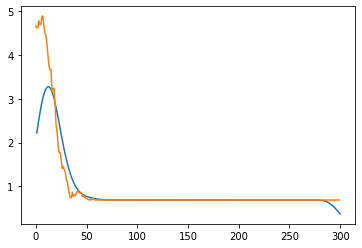

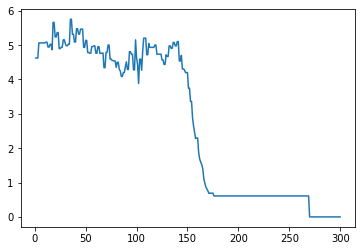

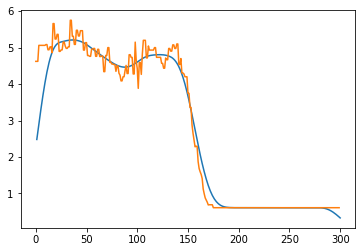

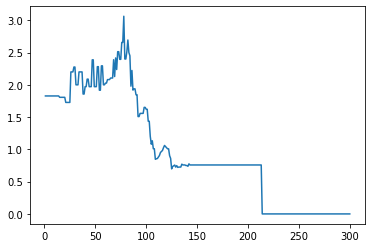

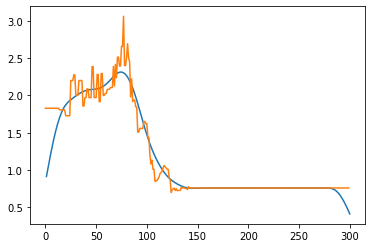

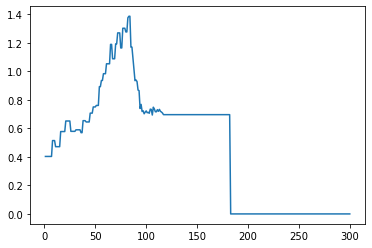

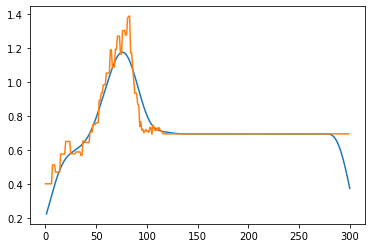

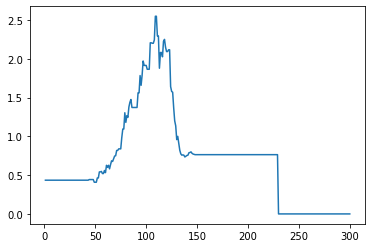

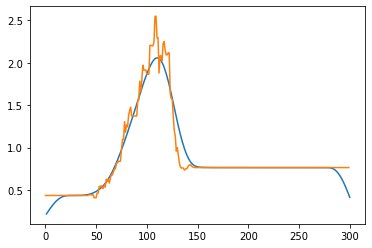

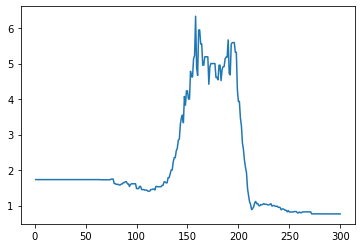

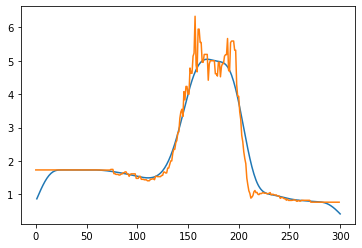

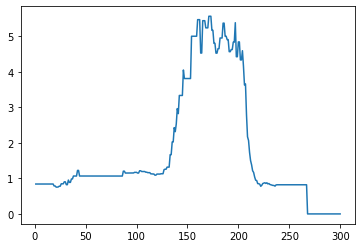

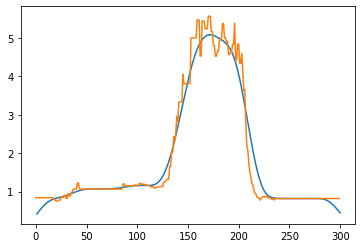

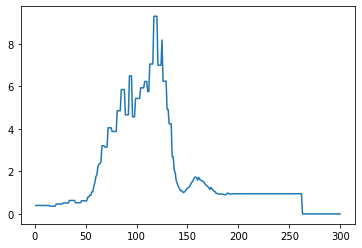

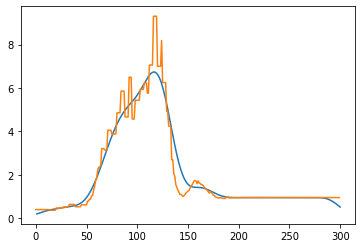

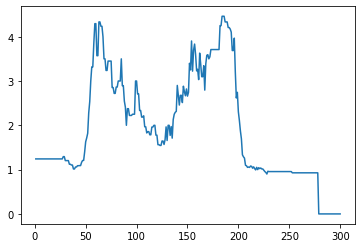

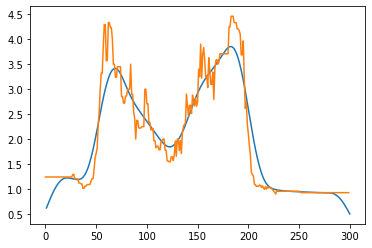

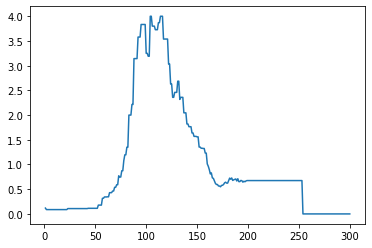

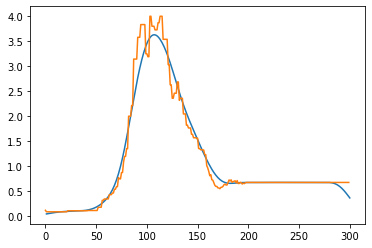

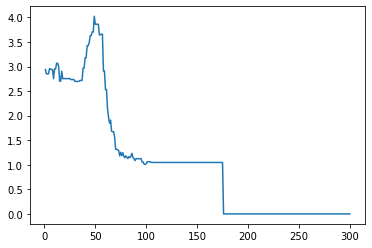

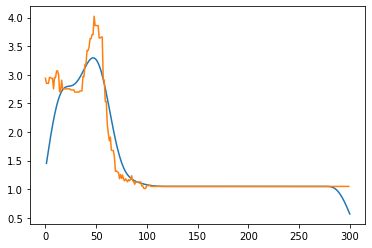

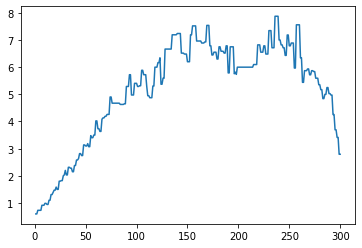

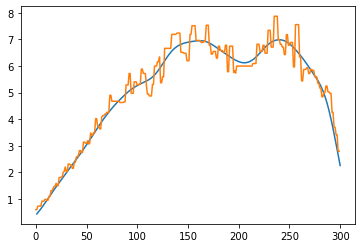

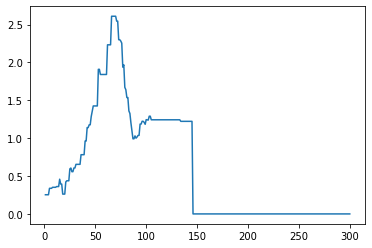

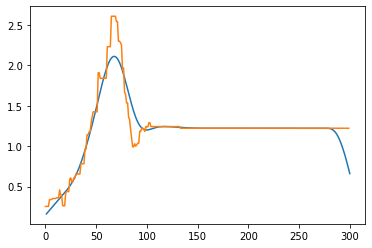

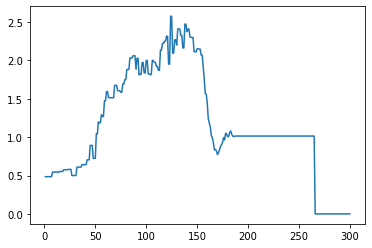

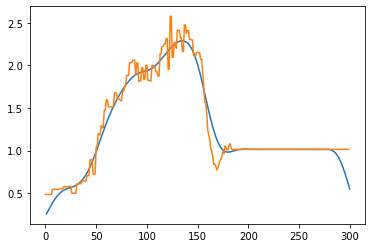

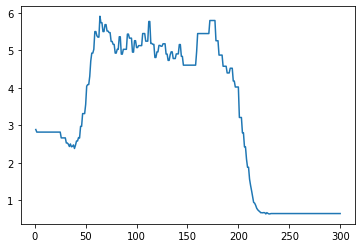

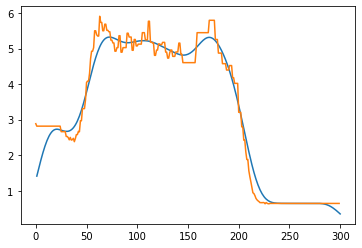

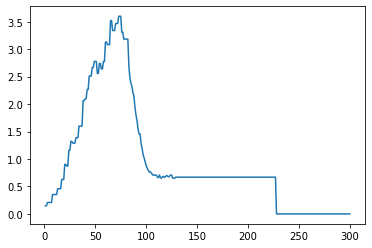

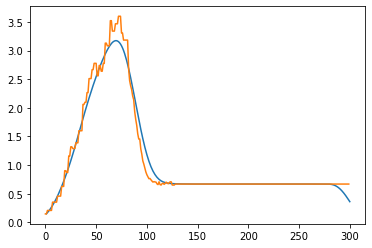

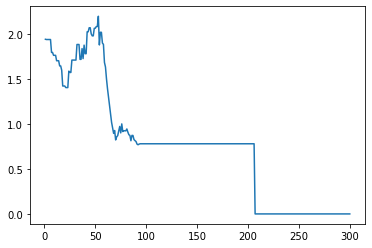

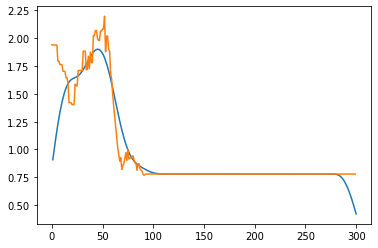

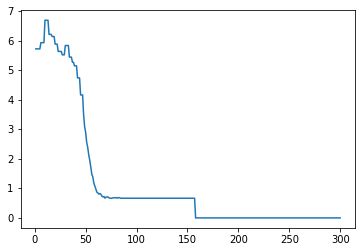

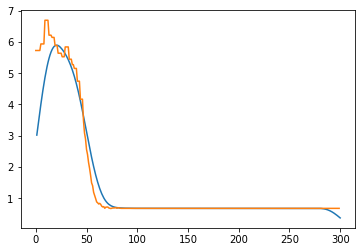

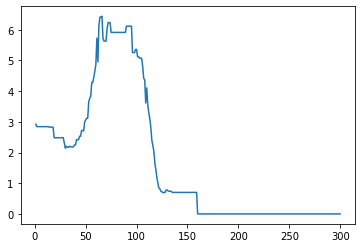

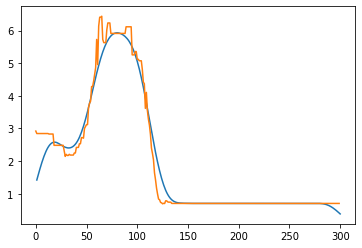

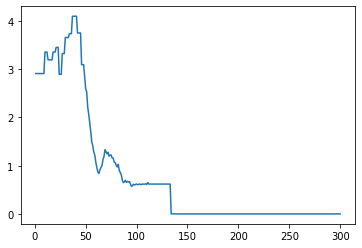

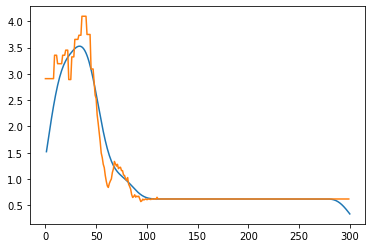

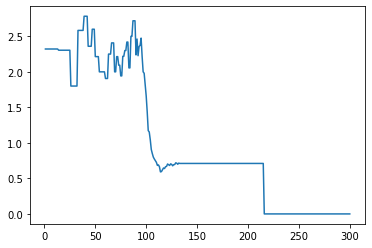

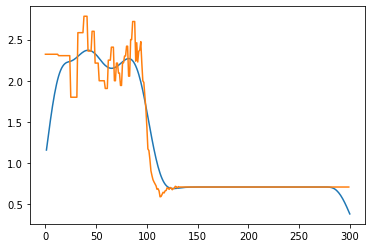

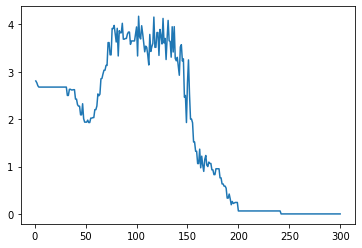

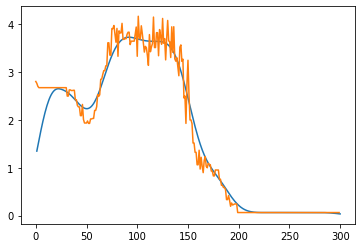

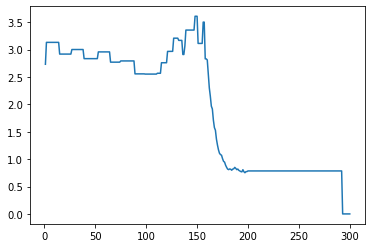

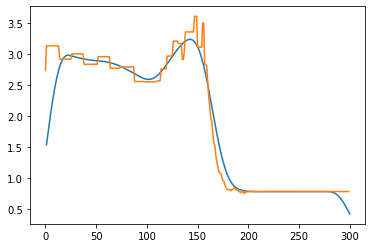

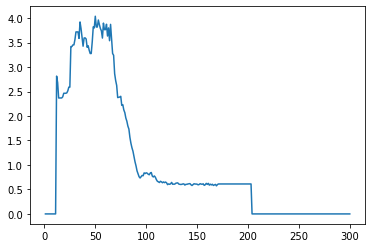

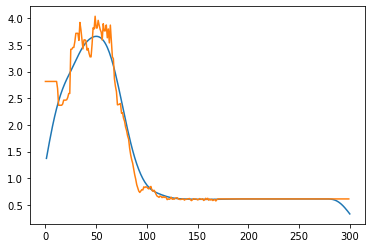

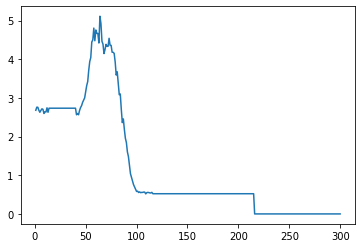

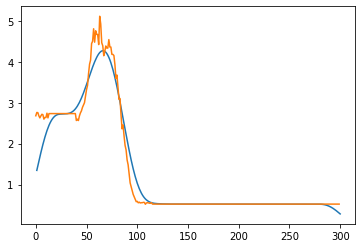

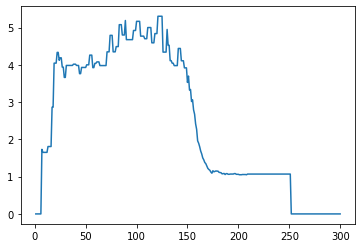

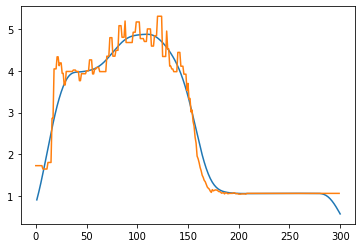

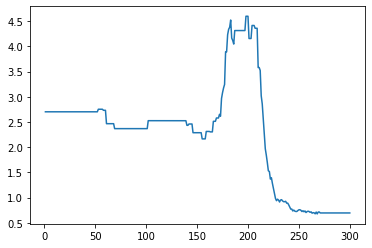

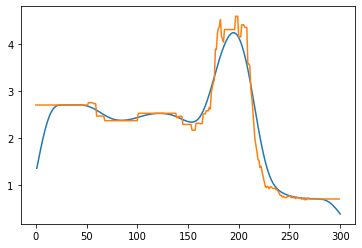

In [21]:
# Интерполяция и сглаживание сверткой значений отношений сторон бокса

x_ratio = []
for video in x_all:
    frames = [el for el in range(1, 301)]
    Ycoord = []
    id_to_del = []
    for frame in video:
        Ycoord.append(frame[0])
    for index, val in enumerate(Ycoord):
        if val==0:
            id_to_del.append(index)
    id_to_del.reverse()
    
    plt.plot(range(1,301), Ycoord)
    plt.show()
    
    for el in id_to_del:
        frames.pop(el)
        Ycoord.pop(el)
    
   
    
    
    Ycoord = np.interp(range(1,301),frames,Ycoord)
#     plt.plot(range(1,301), Ycoord)
#     plt.show()
    
    x_conv = np.array(range(1,301)).astype(float)
    y_conv = np.array(Ycoord).astype(float)

    w = np.hanning(50)
    y_conv = np.convolve(w/w.sum(), y_conv, mode='same')
    x_ratio.append(y_conv.tolist())
    plt.plot(x_conv, y_conv, Ycoord)
    plt.show()

In [24]:
#анализ значений скорости



300

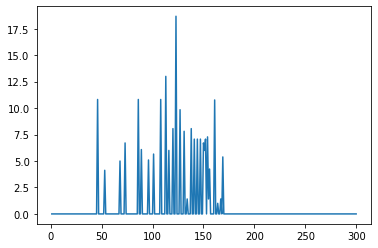

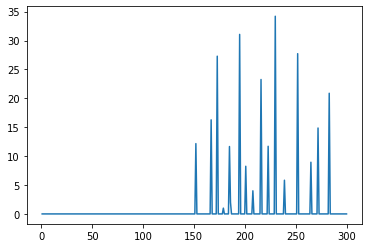

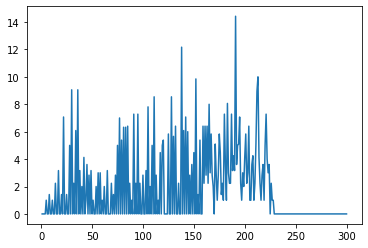

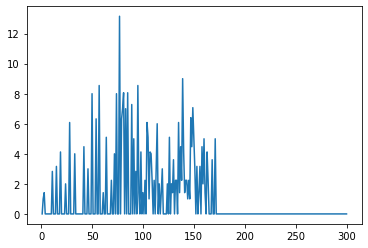

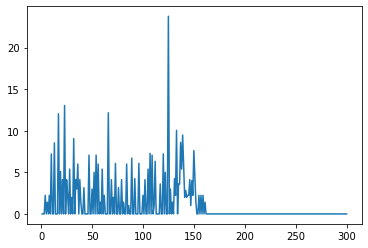

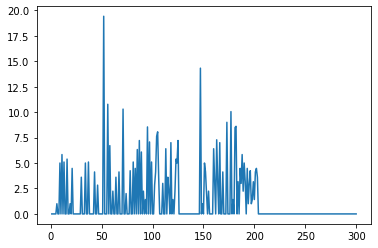

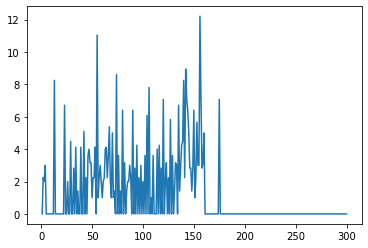

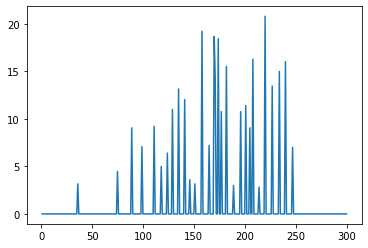

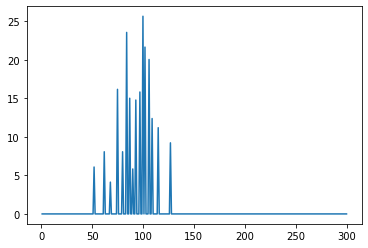

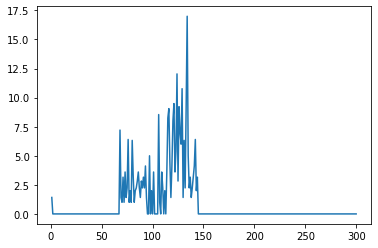

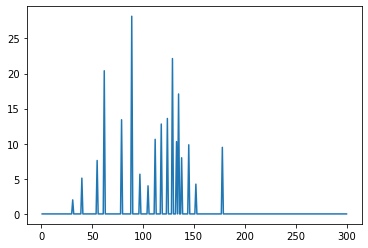

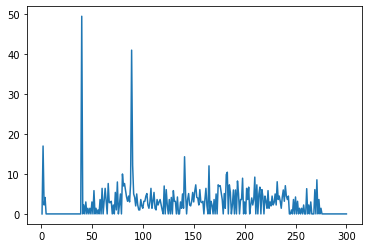

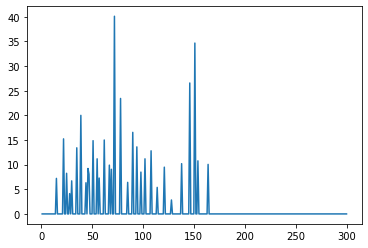

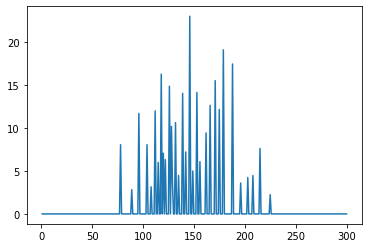

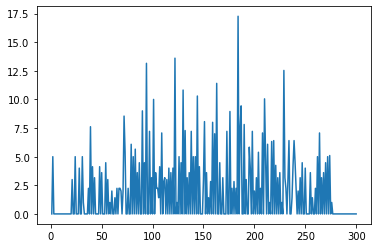

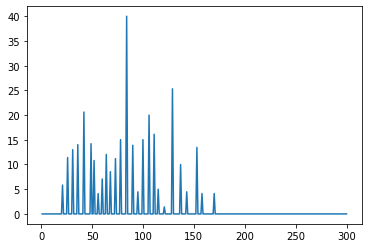

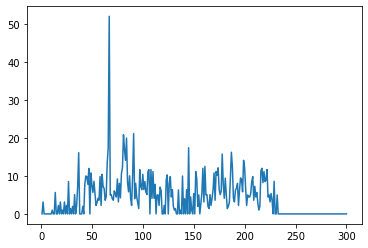

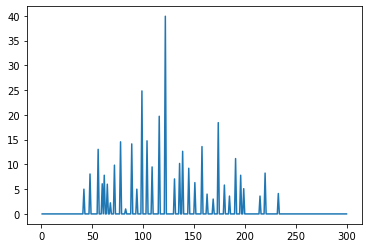

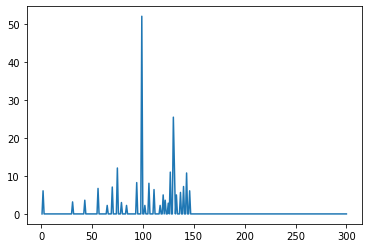

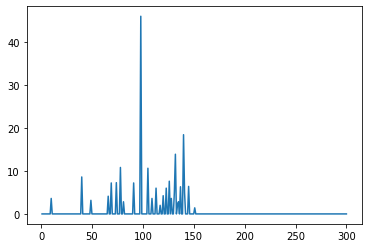

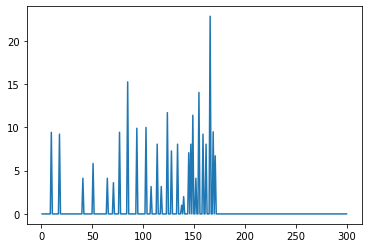

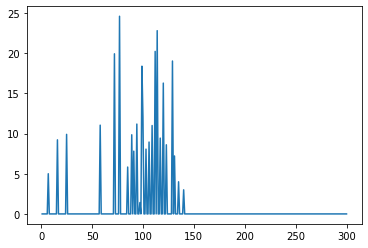

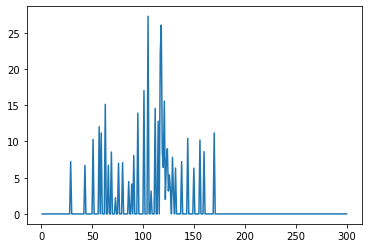

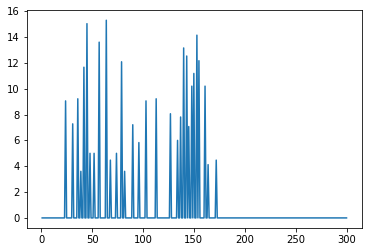

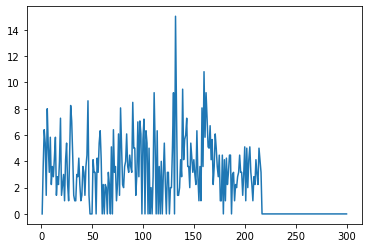

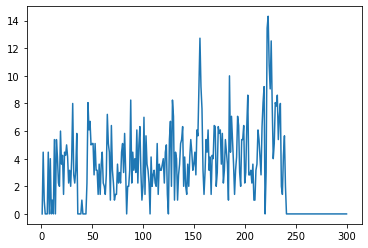

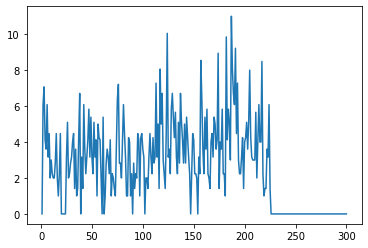

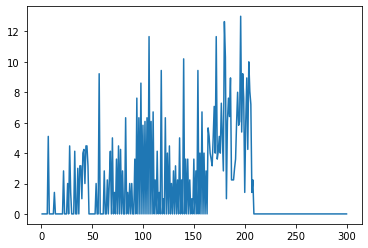

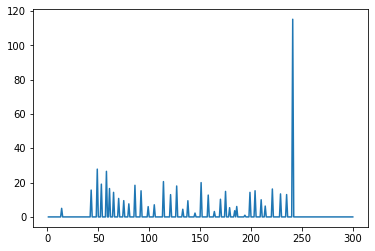

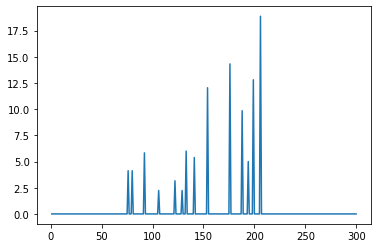

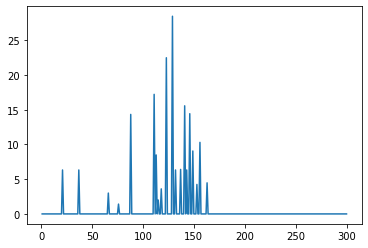

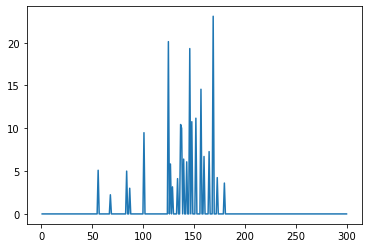

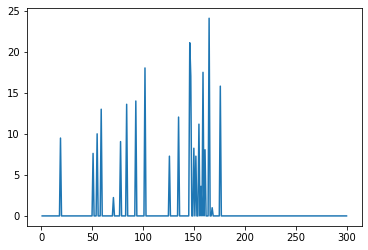

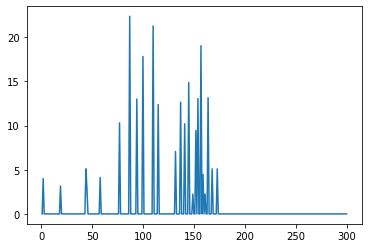

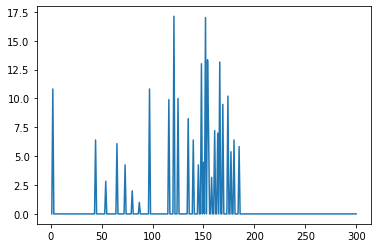

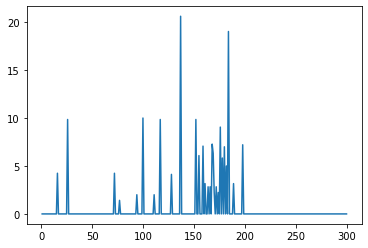

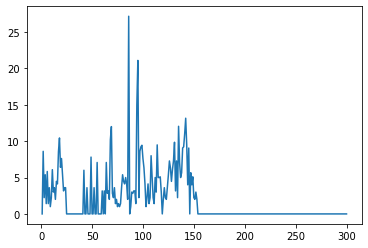

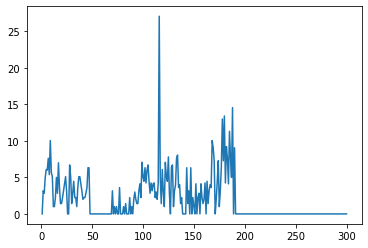

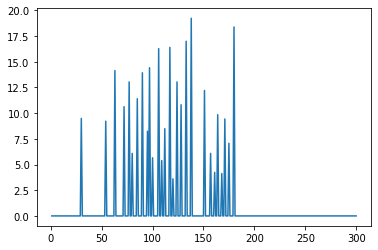

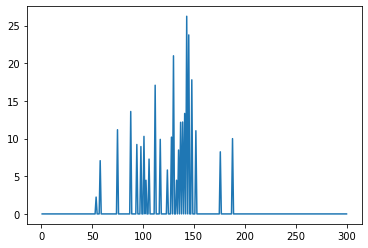

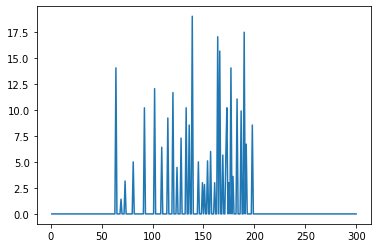

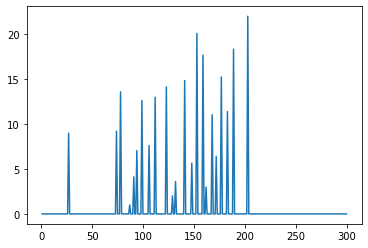

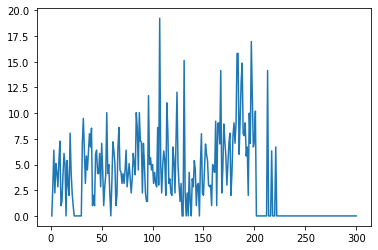

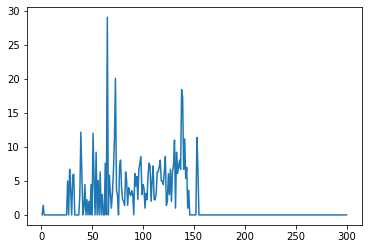

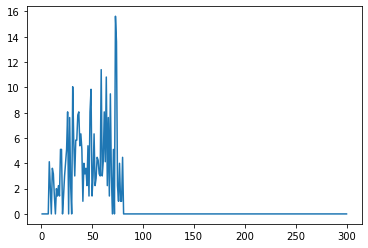

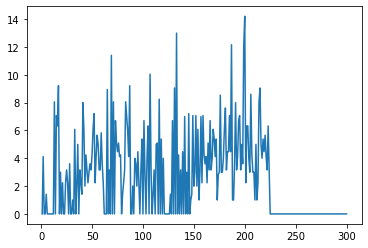

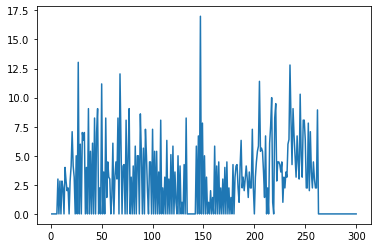

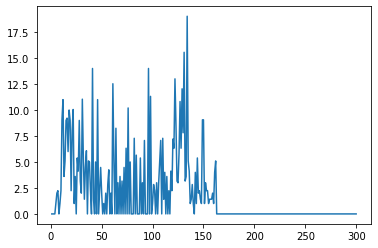

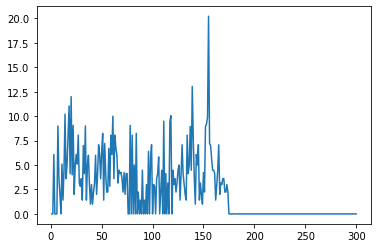

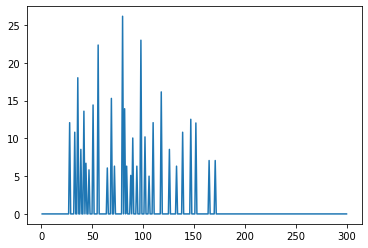

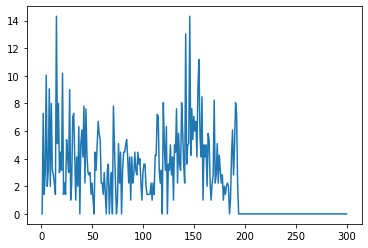

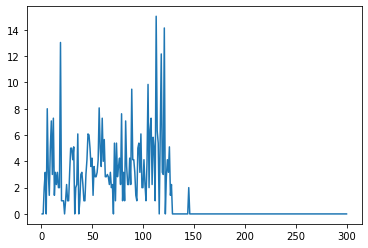

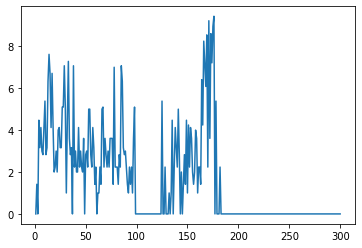

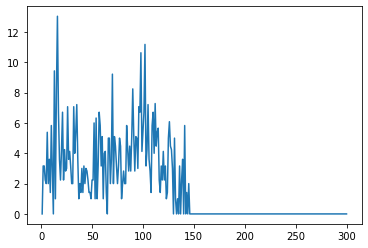

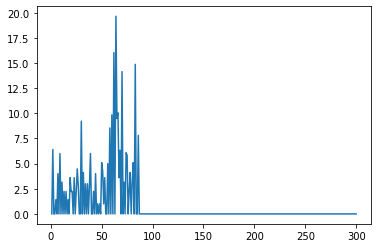

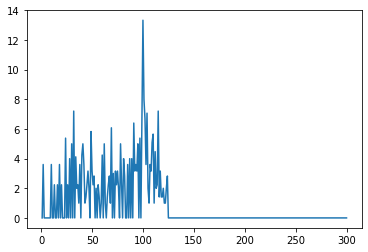

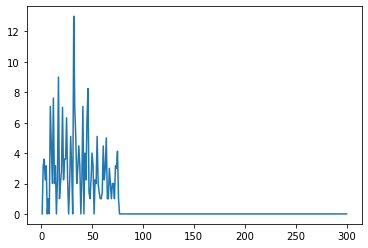

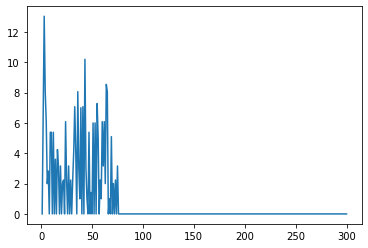

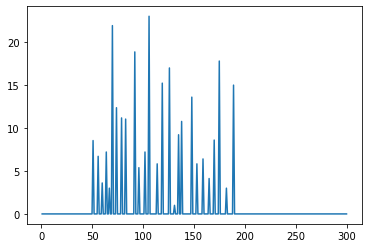

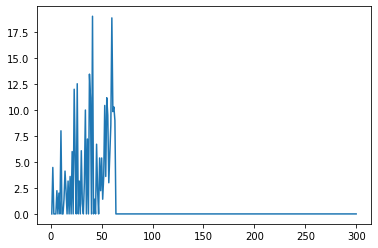

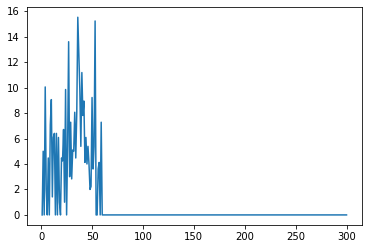

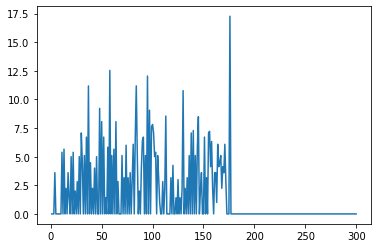

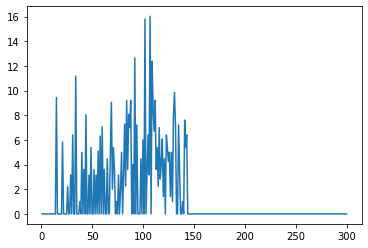

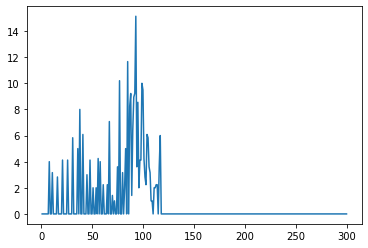

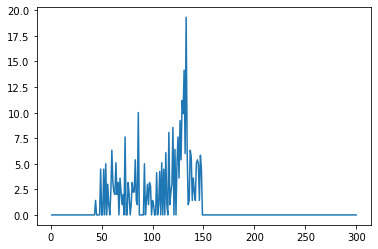

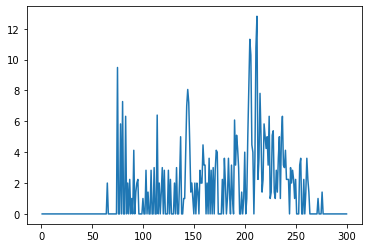

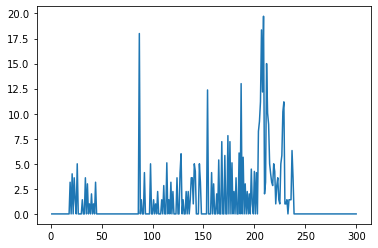

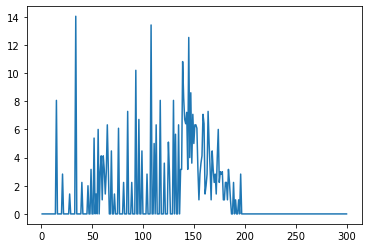

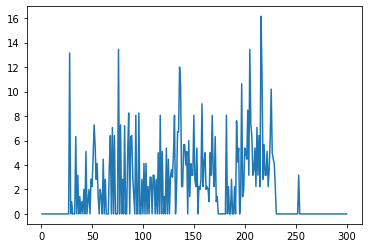

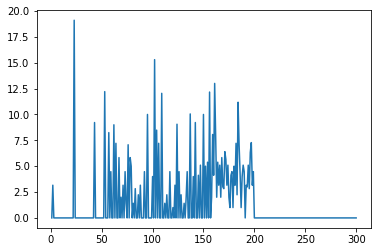

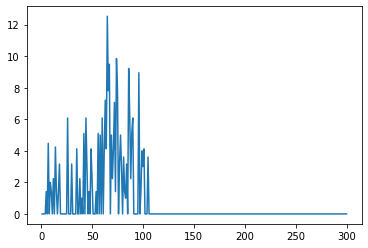

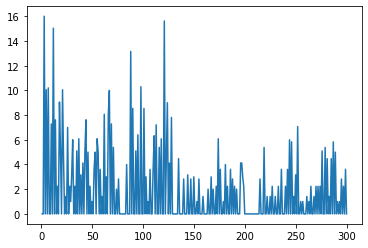

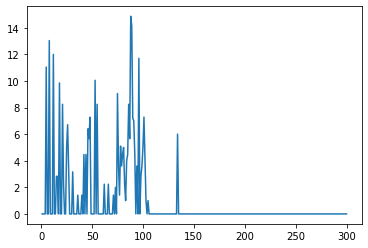

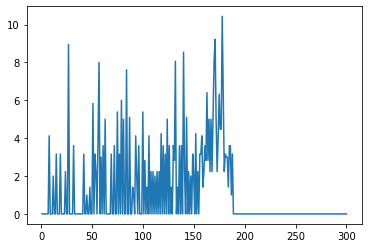

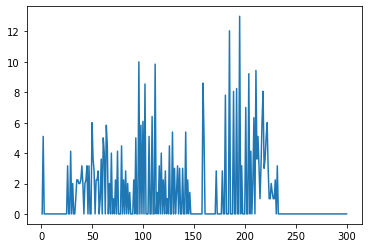

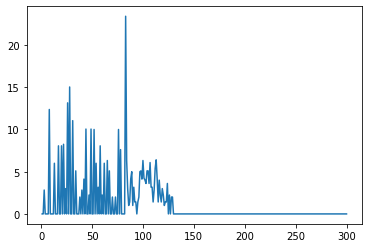

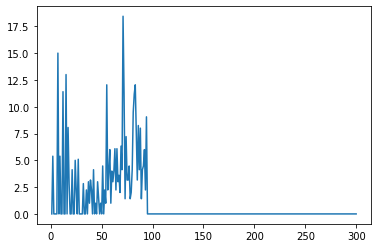

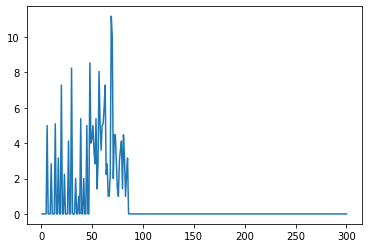

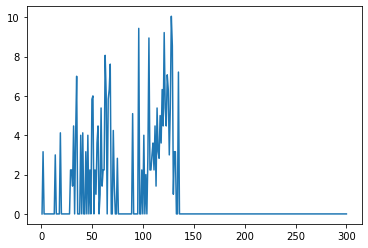

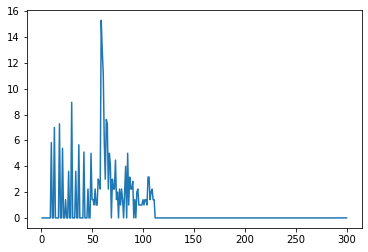

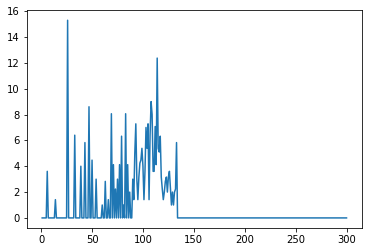

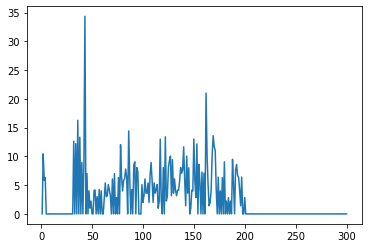

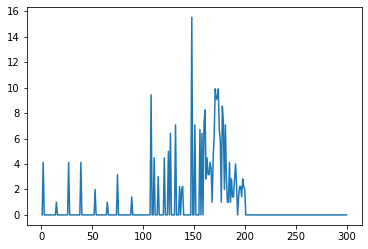

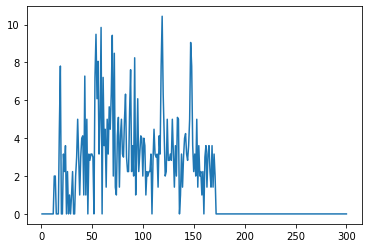

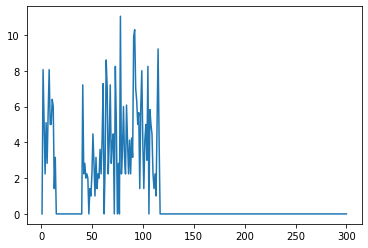

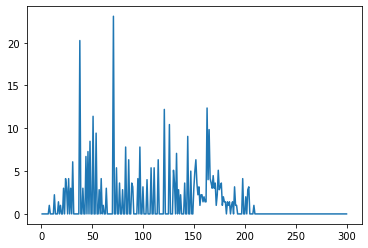

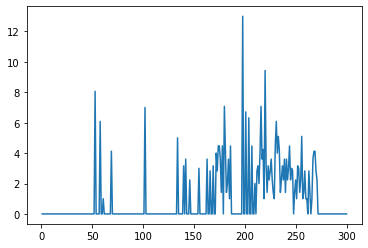

In [26]:
# Интерполяция и сглаживание сверткой значений скорости
x_speed = []
for video in x_all:
    frames = [el for el in range(1, 301)]
    Ycoord = []
    id_to_del = []
    for frame in video:
        Ycoord.append(frame[1])
    x_speed.append(Ycoord)
    
    plt.plot(range(1,301), Ycoord)
    plt.show()
    

In [29]:
#нормирование значений


def normalize_data(data):
    result = []
    for el in data:
        line_max = max(el)
        line_min = min(el)
        line_result = []
        for i in el:
            line_result.append((i-line_min)/(line_max-line_min))
        result.append(line_result)
    return result

x_ratio_norm = normalize_data(x_ratio)
x_speed_norm = normalize_data(x_speed)
x_ratio_norm, x_speed_norm


([[0.2554001916492964,
   0.2821173004030741,
   0.30861528763109136,
   0.33467862977698287,
   0.3600989401446152,
   0.38467839060187653,
   0.4082329599131367,
   0.43059545536284777,
   0.45161825805531286,
   0.4711757468128703,
   0.4891663608721594,
   0.5055142675090464,
   0.5201706072098577,
   0.5331142959432451,
   0.544352371359396,
   0.5539198772320129,
   0.5618792880405173,
   0.5683194831408263,
   0.5733542873687832,
   0.5771206020395024,
   0.579776157031558,
   0.5814969208667395,
   0.5824692901051404,
   0.5828870287187939,
   0.5829530076992585,
   0.5828758739215444,
   0.5827568378375234,
   0.5825880116031076,
   0.5823623249271016,
   0.5820665296001833,
   0.5816814170301345,
   0.5811892452113999,
   0.5805740300483275,
   0.5798218078135781,
   0.5789208644321412,
   0.5778619278261234,
   0.5766383201620111,
   0.5752460675005121,
   0.5736839650485288,
   0.5719535969418273,
   0.5700593102335725,
   0.5680081435158351,
   0.5658097113461041,
   0.563

In [39]:
#конкатенация

x_all = []
for i in range(len(x_ratio_norm)):
    x_all.append([x_ratio_norm[i], x_speed_norm[i]])
        

npx = np.asarray(x_all)
npx.shape

(87, 2, 300)

In [43]:
data = open('y.txt', 'rb')
y = pickle.load(data)
data.close()
print(len(y))

87


In [44]:
#Разбиение выборки на обучающие и тестовые подвыборки

In [34]:
model = Sequential()
model.add(Embedding(40000, 128, input_length = 300))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(0.0001))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 300, 128)          5120000   
_________________________________________________________________
lstm_16 (LSTM)               (None, 300, 128)          131584    
_________________________________________________________________
lstm_17 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 5,301,057
Trainable params: 5,301,057
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.fit(x_train, y_train, batch_size=32, epochs=60)

Epoch 1/60
3/3 [==============================] - 5s 389ms/step - loss: 0.0000e+00 - accuracy: 0.8430
Epoch 2/60
3/3 [==============================] - 1s 377ms/step - loss: 0.0000e+00 - accuracy: 0.8742
Epoch 3/60
3/3 [==============================] - 1s 369ms/step - loss: 0.0000e+00 - accuracy: 0.8352
Epoch 4/60
3/3 [==============================] - 1s 375ms/step - loss: 0.0000e+00 - accuracy: 0.8273
Epoch 5/60
3/3 [==============================] - 1s 396ms/step - loss: 0.0000e+00 - accuracy: 0.8742
Epoch 6/60
3/3 [==============================] - 1s 435ms/step - loss: 0.0000e+00 - accuracy: 0.8313
Epoch 7/60
3/3 [==============================] - 1s 373ms/step - loss: 0.0000e+00 - accuracy: 0.8586
Epoch 8/60
3/3 [==============================] - 1s 421ms/step - loss: 0.0000e+00 - accuracy: 0.8586
Epoch 9/60
3/3 [==============================] - 1s 399ms/step - loss: 0.0000e+00 - accuracy: 0.8352
Epoch 10/60
3/3 [==============================] - 1s 351ms/step - loss: 0.0000e+0

In [36]:
num = 0
res = model.predict(x_test[num])
print(y_test[num])
print(res)

[1]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
